In [1]:
import os
import pandas as pd
import numpy as np
import time
import pickle
import random
random.seed(0)

import matplotlib.pyplot as plt

import lightgbm as lgb

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [4]:
from process import type_score

In [5]:
train_data = '20190715_dist_ang_ori_bond_cos_train_{}.pickle'
trained_models = '20190715_3_champs_models_lgb_{}.pickle'
pred_train_name = '20190715_2_predict_train.pickle'
pred_train_temp = 'predict_train_temp_{}.pickle'
pred_val_name = '20190715_2_predict_val.pickle'
pred_val_temp = 'predict_val_temp_{}.pickle'

In [6]:
# df = pd.DataFrame()
# bond_types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
# for b in bond_types:
#     df_bond = pd.read_pickle(OUTPUT + train_data.format(b))
#     df = pd.concat([df, df_bond], axis=0)

In [49]:
df = pd.read_pickle(OUTPUT + train_data.format("1JHC")).fillna(0)
df.shape

(709416, 229)

In [50]:
mols = df['molecule_name'].unique()
num = len(mols)
num_train = int(num * 0.95)
pickup = random.sample(range(num), num)
pick_train = pickup[:num_train]
pick_val = pickup[num_train:]

In [51]:
df_train_b = df[df['molecule_name'].isin(mols[pick_train])]
df_val_b = df[df['molecule_name'].isin(mols[pick_val])]

In [52]:
y_train = df_train_b['scalar_coupling_constant'].values
X_train = df_train_b[df_train_b.columns[6:]].values

y_val = df_val_b['scalar_coupling_constant'].values
X_val = df_val_b[df_val_b.columns[6:]].values

In [53]:
# rounds = 500000
# num_seed = 1
# # bond_types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
# bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']

In [87]:
def type_score(val, pred):
    return np.log(sum(np.abs(val - pred)) / len(val))

In [54]:
from keras.layers.normalization import BatchNormalization

In [91]:
# シーケンシャルモデル
model = Sequential()

model.add(Dense(64, input_dim=223))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(16))
model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Dense(1))

# モデルの要約を出力
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 64)                14336     
_________________________________________________________________
batch_normalization_30 (Batc (None, 64)                256       
_________________________________________________________________
activation_32 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32)                128       
_________________________________________________________________
activation_33 (Activation)   (None, 32)                0         
__________

In [92]:
model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train,
          batch_size=128,
          nb_epoch=5,
          verbose=1,
          validation_data=(X_val, y_val))

# 評価
score = model.evaluate(X_val, y_val, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 673886 samples, validate on 35530 samples
Epoch 1/5
673886/673886 [==============================] - 38s 56us/step - loss: 42.5111 - mean_absolute_error: 42.5111 - val_loss: 9.5058 - val_mean_absolute_error: 9.5058
Epoch 2/5
673886/673886 [==============================] - 34s 50us/step - loss: 6.7960 - mean_absolute_error: 6.7960 - val_loss: 4.9346 - val_mean_absolute_error: 4.9346
Epoch 3/5
673886/673886 [==============================] - 35s 52us/step - loss: 4.2932 - mean_absolute_error: 4.2932 - val_loss: 3.7299 - val_mean_absolute_error: 3.7299
Epoch 4/5
673886/673886 [==============================] - 34s 51us/step - loss: 3.6229 - mean_absolute_error: 3.6229 - val_loss: 3.6468 - val_mean_absolute_error: 3.6468
Epoch 5/5
673886/673886 [==============================] - 32s 47us/step - loss: 3.3276 - mean_absolute_error: 3.3276 - val_loss: 3.5076 - val_mean_absolute_error: 3.5076
Test loss : 3.507555732920309
Test accuracy : 3.507555732920309


In [93]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

mean-ensemble score train: 16.16
mean-ensemble score valid: 13.45


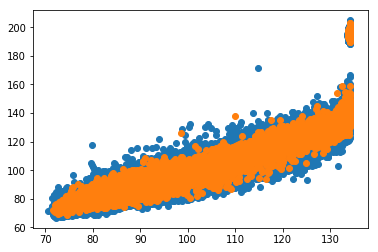

In [94]:
score_train = type_score(y_train_pred[0], y_train)
score_val = type_score(y_val_pred[0], y_val)

print('mean-ensemble score train: %.2f' % score_train)
print('mean-ensemble score valid: %.2f' % score_val)

plt.scatter(y_train_pred, y_train)
plt.scatter(y_val_pred, y_val)
plt.show()

---------- 3JHN ----------
seed No.0, bond type 3JHN
best iteration: 335155
single model score valid: -2.24
elapsed_time:5478.49[sec]
mean-ensemble score train: -3.70
mean-ensemble score valid: -2.24


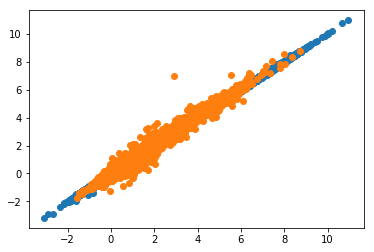

/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ryoji/Documents/git/kaggle/ml/lib/python3.6/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---------- 3JHC ----------
seed No.0, bond type 3JHC


KeyboardInterrupt: 

In [10]:
# models = []
# scores = []
# start0 = time.time()

# for i, b in enumerate(bond_types):
#     print('-'*10, b, '-'*10)
    
#     models_b = []
#     y_train_pred_b =[]
#     y_val_pred_b =[]
    
#     df_train_b = df_train.query('type == "{}"'.format(b))
#     y_train = df_train_b['scalar_coupling_constant'].values
#     X_train = df_train_b[df_train.columns[6:]].values

#     df_val_b = df_val.query('type == "{}"'.format(b))
#     y_val = df_val_b['scalar_coupling_constant'].values
#     X_val = df_val_b[df_val.columns[6:]].values

#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
#     for s in range(num_seed):
#         print('seed No.{}, bond type {}'.format(s, b))
#         start = time.time()

#         params = {
#                 'task' : 'train',
#                 'boosting_type' : 'gbdt',
#                 'objective' : 'regression',
#                 'metric' : {'l1'},
#                 'num_leaves' : 63,
#                 'learning_rate' : 0.001,
#                 'feature_fraction' : 0.7,
#                 'bagging_fraction' : 0.7,
#                 'bagging_freq': 5,
#             'seed':s
#         }

#         gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=rounds,
#                 verbose_eval=0,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=20)

#         models_b.append(gbm)
        
#         y_train_pred_single = gbm.predict(X_train, num_iteration=gbm.best_iteration)
#         y_train_pred_b.append(y_train_pred_single)
        
#         y_val_pred_single = gbm.predict(X_val, num_iteration=gbm.best_iteration)
#         y_val_pred_b.append(y_val_pred_single)
        
#         print('best iteration: %.f' % gbm.best_iteration)
#         print('single model score valid: %.2f' % type_score(y_val, y_val_pred_single))
#         elapsed_time = time.time() - start
#         print ("elapsed_time:%.2f" % elapsed_time + "[sec]")
        
#     y_train_pred = np.array(y_train_pred_b).mean(axis=0)
#     y_val_pred = np.array(y_val_pred_b).mean(axis=0)
    
#     score_train = type_score(y_train_pred, y_train)
#     score_val = type_score(y_val_pred, y_val)
    
#     print('mean-ensemble score train: %.2f' % score_train)
#     print('mean-ensemble score valid: %.2f' % score_val)
    
#     plt.scatter(y_train_pred, y_train)
#     plt.scatter(y_val_pred, y_val)
#     plt.show()
    
#     df_train_b['predict'] = y_train_pred
#     df_train_b.to_pickle(OUTPUT +  pred_train_temp.format(b))

#     df_val_b['predict'] = y_val_pred
#     df_val_b.to_pickle(OUTPUT + pred_val_temp.format(b))
    
#     with open(OUTPUT + trained_models.format(b), 'wb') as f:
#         pickle.dump(models_b, f)

#     scores.append(score_val)
# elapsed_time = time.time() - start0
# print ("total elapsed_time:%.2f" % (elapsed_time/3600) + "[hours]")


In [ ]:
print('type score:', scores)
print('total score:', np.array(scores).mean())

# bond_types = ['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']

# type score: [-0.6475891072986386, -1.9721361628331164, -1.1912367029788065, -1.7391610037264984, -1.3598948274113396, -1.922368782849765, -0.857338974637314, -1.9542739523641741]
# total score: -1.4554999392624568

# type score: [-0.7645330704903743, -2.104084028025536, -1.3402588845078518, -1.8923981460798822, -1.500998060101688, -2.058753881131865, -0.9890402466066893, -2.0696881437055095]
# total score: -1.5899693075811745

# type score: [-0.7487882321683186, -2.154929679183851, -1.3385395863448157, -1.9494073155134974, -1.4796858054598758, -2.0678527290735764, -0.8668322021931907, -2.0989929940604086]
# total score: -1.588128567999692

# bond_types = ['3JHN', '3JHC','1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH']
# type score: [-2.151210567127715, -1.187568725302376, -0.6614562939594398, -2.0944129825221665, -1.372642157023402, -1.9124487059330253, -1.3387502372065168, -1.9828684571550126]
# total score: -1.5876697657787067

# type score: [-2.2228464134469648, -1.3176652237271005, -0.7691147220693114, -2.177655669465094, -1.3849037075799966, -1.991064979196199, -1.4601645925001645, -2.078594552382417]
# total score: -1.675251232545906

# type score: [-2.145429318690866, -1.294058684027914, -0.760119859244144, -2.139005467865551, -1.350309811202638, -1.9229016015078875, -1.4390039122302951, -2.0494419940987965]
# total score: -1.6375338311085113

# type score: [-2.209404721041051, -1.2277751365676979, -0.6895477849524412, -2.106917882503863, -1.378567767938254, -1.9432313732668243, -1.3771493620532902, -2.037484717400561]
# total score: -1.6212598432154977

# type score: [-2.213330811075121, -1.3581258350105094, -0.7845050130296711, -2.1655013094988513, -1.4024121799402647, -1.9751865470643377, -1.499394936229838, -2.1188348800106724]
# total score: -1.689661438982408

In [ ]:
# df_train_predict = pd.DataFrame()
# df_val_predict = pd.DataFrame()

# for b in bond_types:
#     df_train_predict_b = pd.read_pickle(OUTPUT + pred_train_temp.format(b))
#     df_train_predict = pd.concat([df_train_predict, df_train_predict_b], axis=0)
    
#     df_val_predict_b = pd.read_pickle(OUTPUT + pred_val_temp.format(b))
#     df_val_predict = pd.concat([df_val_predict, df_val_predict_b], axis=0)

# df_train_predict.to_pickle(OUTPUT + pred_train_name)
# df_val_predict.to_pickle(OUTPUT + pred_val_name)